In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
# 
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

In [2]:
import os
# NOTE: set the gpu here if necessary
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# NOTE: add these to your PYTHONPATH
import sys
sys.path.insert(0, "../")

import torch as th
import numpy as np
from omegaconf import OmegaConf

# TODO: put this
from dva.utils import to_device
from torch.utils.data import DataLoader

# TODO: open-source MVP instead?
from dva.ray_marcher import RayMarcher, generate_colored_boxes
from dva.zju_dataset import ZJUDataset
from dva.io import load_static_assets, load_from_config

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

# removing all the warnings
import warnings
warnings.filterwarnings('ignore')


device = th.device("cuda:0")

In [3]:
# set the root here if necessary
dva_root_dir = os.path.abspath('../')

config_path = '../configs/sample_386.yml'
config = OmegaConf.load(config_path)
config.smplx_dir = f'{dva_root_dir}/{config.smplx_dir}'
config.root_data_dir = f'{dva_root_dir}/{config.root_data_dir}'

In [4]:
static_assets = load_static_assets(config)

decoder = load_from_config(
    config.model,
    assets=static_assets,
)

# computing values for the given viewpoints
rm = RayMarcher(
    config.image_height,
    config.image_width,
    **config.rm,
).to(device)

decoder, rm = to_device((decoder, rm), device)

dataset = ZJUDataset(
    **config.data,
    cameras=config.cameras_train,
    # NOTE: these should be a subset of train
    cond_cameras=config.cameras_cond,
)

In [5]:
# # NOTE: uncomment and change ckpt here once your model is trained!
# ckpt_path = f'{dva_root_dir}/data/zju_lightstage/386/training-logs/cond_model_mvp/checkpoints/100000.pt'
# ckpt_params = th.load(ckpt_path)
# decoder.load_state_dict(ckpt_params['model_state_dict'])

In [6]:
loader = DataLoader(
    dataset,
    batch_size=4,
    pin_memory=False,
    num_workers=1,
    drop_last=False,
    shuffle=True,
    worker_init_fn=lambda _: np.random.seed(),
)

In [7]:
# reading a sample
batch = to_device(next(iter(loader)), device)

### rendering outputs of the model: RGB, primitives and masks

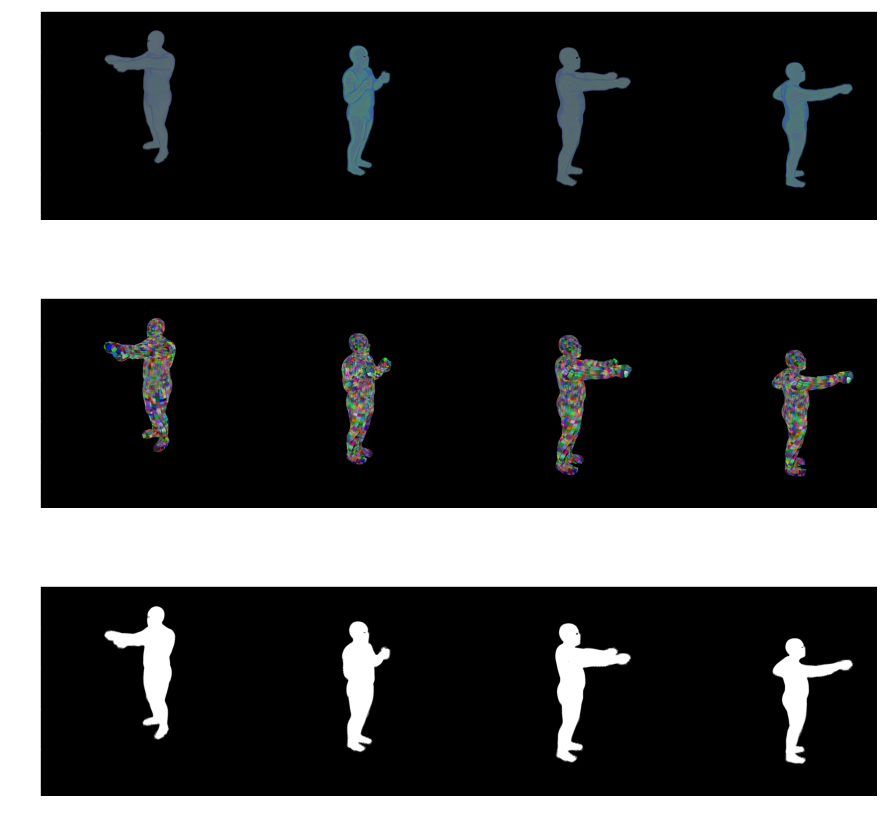

In [9]:
with th.no_grad():
    preds = decoder(**batch, train_iter=1000)

    rm_preds = rm(
        prim_rgba=preds['prim_rgba'],
        prim_pos=preds["prim_pos"],
        prim_scale=preds["prim_scale"],
        prim_rot=preds["prim_rot"],
        RT=batch["Rt"],
        K=batch["K"],
    )
    rgb = rm_preds['rgba_image'][:,:3].to(th.uint8)
    alpha = rm_preds['rgba_image'][:,-1:]

    slab_boxes = generate_colored_boxes(preds['prim_rgba'].clone(), preds['prim_rot'])    
    
    rm_preds_boxes = rm(
        prim_rgba=slab_boxes,
        prim_pos=preds["prim_pos"],
        prim_scale=preds["prim_scale"],
        prim_rot=preds["prim_rot"],
        RT=batch["Rt"],
        K=batch["K"],
    )
    rgb_boxes = rm_preds_boxes['rgba_image'][:,:3].clip(0, 255).to(th.uint8)

rgb_grid = make_grid(rgb).cpu()
alpha_grid = make_grid(alpha).cpu()
rgb_boxes_grid = make_grid(rgb_boxes).cpu()

plt.figure(figsize=(15, 15))
plt.subplot(3,1,1)
plt.imshow(rgb_grid.permute(1, 2, 0))
plt.subplot(3,1,2)
plt.imshow(rgb_boxes_grid.permute(1, 2, 0))
plt.subplot(3,1,3)
plt.imshow(alpha_grid.permute(1, 2, 0))    